Unsupervised learning, визуализация.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.utils import save_image

/home/artemiy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/artemiy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/artemiy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/artemiy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Часть 0. Загрузка данных, преобразование, обучение автоэнкодера.
Будем работать с датасетом `FashionMNIST` ([ссылка](https://github.com/zalandoresearch/fashion-mnist)). Снова десять классов, но теперь объекты представляют собой изображения предметов одежды размером `28 x 28`. Доступны следующие метки классов:
*   'T-shirt/top',
*   'Trouser',
*   'Pullover',
*    'Dress',
*   'Coat',
*   'Sandal',
*   'Shirt',
*   'Sneaker',
*   'Bag',
*   'Ankle boot'

In [3]:
if not os.path.exists('./fashion_img'):
    os.mkdir('./fashion_img')


def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

Определим параметры процесса обучения и "трансформер" данных (он приводит их в нужный формат автоматически).

In [4]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3


img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Датасет `FashionMNIST` доступен напрямую из `torchvision.datasets`.

In [5]:
dataset = FashionMNIST('./fashion_img', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
label_to_name = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

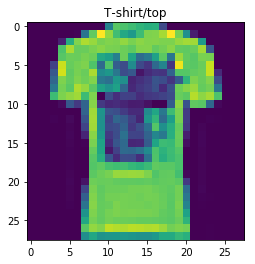

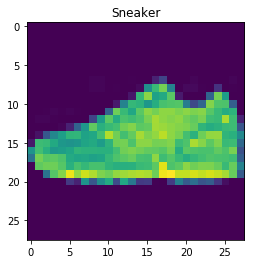

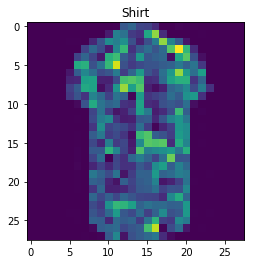

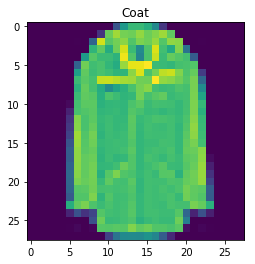

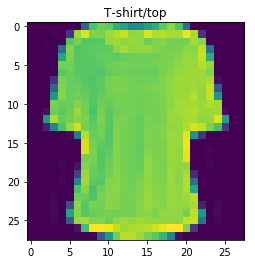

In [7]:
for idx in np.random.choice(np.arange(len(dataloader.dataset)), 5):
    img, label = dataloader.dataset[idx]
    f, (ax1) = plt.subplots(1, 1)
    ax1.imshow(img.numpy().squeeze())
    ax1.set_title(label_to_name[label])

In [8]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_encoded_data(self, x):
        return self.encoder(x)

Воспользуемся автоэнкодером той же структуры, что и на семинаре по Unsupervised learning. Он переводит изображения в латентное пространство размерности 3.

*Комментарий: Вы можете изменить структуру автоэнкодера и посмотреть, что получится (изменить число слоев, увеличить размерность латентного пространства с 3 до ... или сделать вообще что-то свое).*

*Комментарий 2: если вам не хочется ждать, пока автоэнкодер обучится (10-20 минут), можете воспользоваться предобученной сетью. Для этого раскоментируйте соответствующую ячейку.*

In [9]:
model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [10]:
# Если не хочется ждать:
model = torch.load('trained_autoencoder.pt')

/home/artemiy/anaconda3/lib/python3.6/site-packages/torch/serialization.py:425: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [11]:
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        # ===================forward=====================
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data[0]))

Exception ignored in: <bound method Image.__del__ of <PIL.Image.Image image mode=L size=28x28 at 0x7EFBF5979240>>
Traceback (most recent call last):
  File "/home/artemiy/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 589, in __del__
    if (hasattr(self, 'fp') and hasattr(self, '_exclusive_fp')
KeyboardInterrupt
/home/artemiy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


epoch [1/100], loss:0.0808


KeyboardInterrupt: 

Рассмотрим исходные (слева) и восстановленные (справа) изображения.

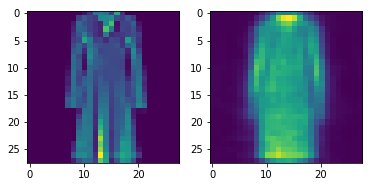

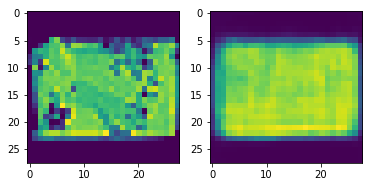

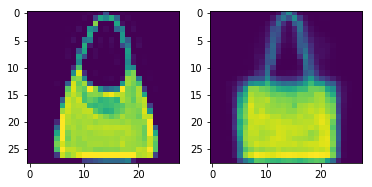

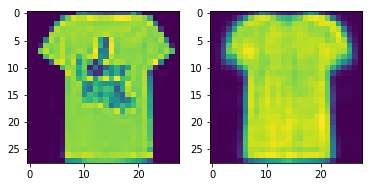

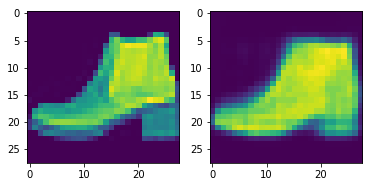

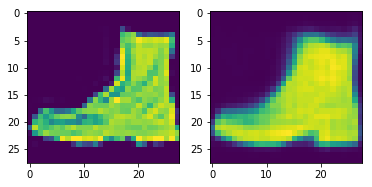

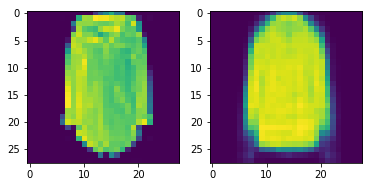

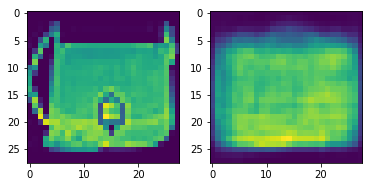

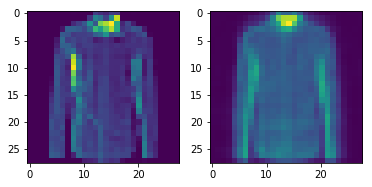

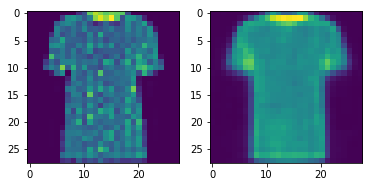

In [12]:
for idx in np.random.choice(np.arange(len(dataloader.dataset)), 10):
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(dataloader.dataset[idx][0].numpy().squeeze())
    
    img, _ = dataloader.dataset[idx]
    img = img.view(img.size(0), -1)
    img = Variable(img)
    result = model(img).detach().numpy().reshape([28, 28])
    
    ax2.imshow(result)

Закодируем `1000` изображений и будем работать с ними далее.

In [13]:
raw_dataset = []
encoded_dateset = []
dataset_labels = []

for idx in np.random.choice(np.arange(len(dataloader.dataset)), 1000, replace=False):
    img, label = dataloader.dataset[idx]
    dataset_labels.append(label.numpy())
    img = img.view(img.size(0), -1)
    img = Variable(img)
    raw_dataset.append(img.numpy())
    encoded = model.get_encoded_data(img)
    encoded_dateset.append(encoded.detach().numpy())

raw_dataset = np.array(raw_dataset).squeeze()
encoded_dateset = np.array(encoded_dateset).squeeze()
dataset_labels = np.array(dataset_labels)

И сделаем построение графиков несколько удобней:

In [14]:
colors = ['red', 'magenta', 'yellow', 'blue', 'green', 'orange', 'cyan', 'black', 'grey', 'purple']
get_color = lambda x: colors[int(x)]

colors_for_plot = list(map(get_color, dataset_labels))

unique_labels = sorted(list(set(dataset_labels)))
unique_labels_loc = {i: np.where(dataset_labels==i)[0][0] for i in unique_labels}

### Часть 1. Визуализация (50%)
Потренируйтесь в построении графиков. Попробуйте отобразить распределение объектов в трехмерном латентном пространстве, построенным автоэнкодером (т.е. постройте визуализацию `encoded_dataset`).  Для визуализации используйте `ax.scatterplot` [инструкция и примеры](https://matplotlib.org/gallery/mplot3d/scatter3d.html). 

*Комментарий: если не получается с 3d, пишите и мы Вам поможем.*

In [22]:
from mpl_toolkits.mplot3d import Axes3D

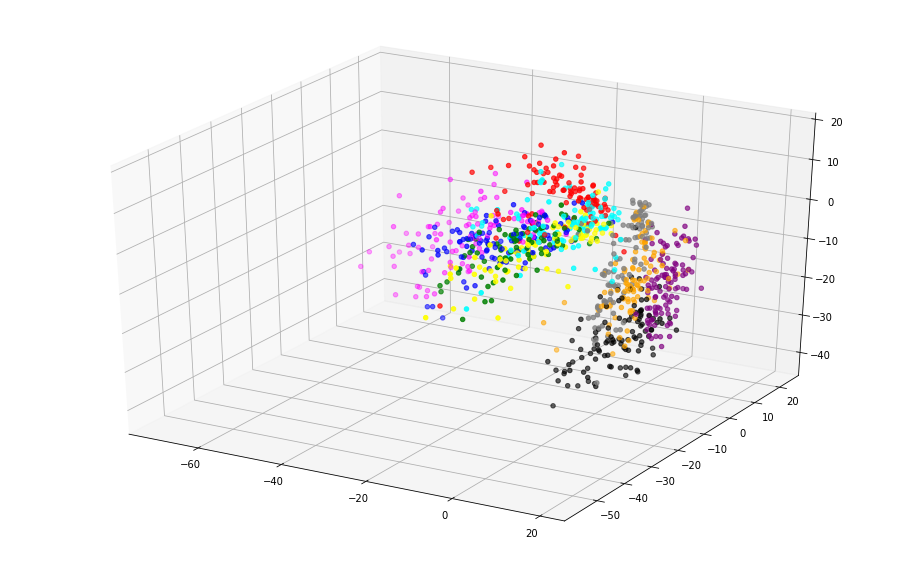

In [28]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
# Ваш код здесь
ax.scatter(encoded_dateset[:,0],encoded_dateset[:,1],encoded_dateset[:,2],c=colors_for_plot)

Теперь трансформируйте датасет с помощью t-SNE. Вас интересует лишь один его метод: `.fit_transform`. Отобразите полученное двумерное распределение точек.

In [29]:
# Ваш код здесь
new_scatters = TSNE(n_components=2).fit_transform(encoded_dateset)

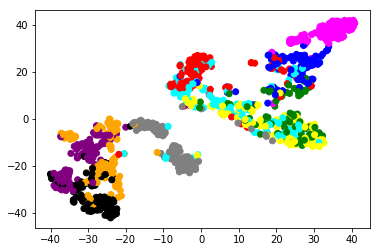

In [30]:
plt.scatter(new_scatters[:,0],new_scatters[:,1],c=colors_for_plot)

Теперь сделайте то же самое, но для необработанных данных (`raw_dataset`). Визуально сравните получившиеся изображения. Получилось похоже?

In [31]:
# Ваш код здесь
new_scatters = TSNE(n_components=2).fit_transform(raw_dataset)

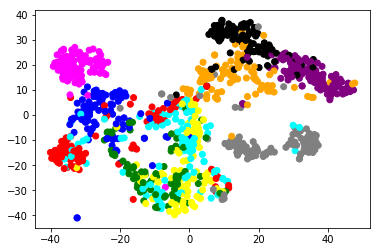

In [34]:
plt.scatter(new_scatters[:,0],new_scatters[:,1],c=colors_for_plot)

Наконец, примените PCA для выделения 2 главных компонент. Отобразите получившееся двумерное распределение точек.

In [119]:
# Ваш код здесь 
pca = PCA(n_components=2)
pca.fit(raw_dataset)
print(pca.singular_values_) 

[284.27502 219.56577]


### Часть 2. Снижение размерности (50%)
Выделим подвыборку из `5000` изображений и будем работать с ними далее. 

In [68]:
raw_dataset = []
encoded_dateset = []
dataset_labels = []

for idx in np.random.choice(np.arange(len(dataloader.dataset)), 1000, replace=False):
    img, label = dataloader.dataset[idx]
    dataset_labels.append(label.numpy())
    img = img.view(img.size(0), -1)
    img = Variable(img)
    raw_dataset.append(img.numpy())
    encoded = model.get_encoded_data(img)
    encoded_dateset.append(encoded.detach().numpy())

raw_dataset = np.array(raw_dataset).squeeze()
encoded_dateset = np.array(encoded_dateset).squeeze()
dataset_labels = np.array(dataset_labels)

Обучите логистическую регрессию на необработанных (`raw_dataset`) данных. Оцените качество классификации на обучающей и тестовой выборках с помощью метрик `accuracy_score` и `f1_score` (для `f1_score` параметр `average='macro'`). Не забудьте разделить выборку на обучение и контроль с параметром `shuffle=True`, и разбиением 80/20 (на обучение и контроль соответственно) Подсказка: `train_test_split`.

In [69]:
# Ваш код здесь
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score
(X_train_raw,X_test_raw,y_train,y_test) = train_test_split(raw_dataset, dataset_labels, test_size=0.2,shuffle=True,
                                                           random_state=42)
estimator_raw = LogisticRegression(random_state=42)
estimator_raw.fit(X_train_raw,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [70]:
predicted_raw = estimator_raw.predict(X_test_raw)
acc_sc_raw = accuracy_score(y_test,predicted_raw)
f1_score_raw = f1_score(y_test,predicted_raw,average='macro')

In [71]:
print('accuracy raw:',acc_sc_raw)
print('f1_score raw:',f1_score_raw)

accuracy raw: 0.81
f1_score raw: 0.8089147821732222


Обучите логистическую регрессию на преобразованных (`encoded_dataset`) данных. Оцените качество классификации на обучающей и тестовой выборках с помощью метрик `accuracy_score` и `f1_score` (для `f1_score` параметр `average='macro'`). Не забудьте разделить выборку на обучение и контроль с теми же параметрами.

In [72]:
# Ваш код здесь
(X_train_enc,X_test_enc) = train_test_split(encoded_dateset,test_size=0.2,shuffle=True,random_state=42)
estimator_enc = LogisticRegression(random_state=42)
estimator_enc.fit(X_train_enc,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [73]:
predicted_enc = estimator_enc.predict(X_test_enc)
acc_sc_enc = accuracy_score(y_test,predicted_enc)
f1_score_enc = f1_score(y_test,predicted_enc,average='macro')

In [74]:
print('accuracy encoded:',acc_sc_enc)
print('f1_score encoded:',f1_score_enc)

accuracy encoded: 0.65
f1_score encoded: 0.6484344631622446


Теперь переберите количество главных компонент от 3 до 100 по следующей сетке: `[3, 7, 12, 18, 25, 40, 55, 75, 80, 85, 90]`, обучите логистическую регрессию на преобразованном датасете и оцените качество на обучающей и тестовой выборках в зависимости от числа компонент. Отобразите значения `accuracy_score` и `f1_score` на тестовой выборке на графике в зависимости от числа компонент.

In [75]:
# Ваш код здесь
from sklearn.model_selection import GridSearchCV
(X_train_enc,X_test_enc) = train_test_split(encoded_dateset,test_size=0.2,shuffle=True,random_state=42)
estimator = LogisticRegression(random_state=12)
C_param = {'C': [3, 7, 12, 18, 25, 40, 55, 75, 80, 85, 90]}
optimizer = GridSearchCV(estimator,C_param,verbose=True)
optimizer.fit(X_train_enc,y_train)

Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    1.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=12, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [3, 7, 12, 18, 25, 40, 55, 75, 80, 85, 90]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=True)

In [76]:
optimizer.best_params_

{'C': 12}

In [77]:
predicted_enc = optimizer.predict(X_test_enc)
acc_sc_enc = accuracy_score(y_test,predicted_enc)
f1_score_enc = f1_score(y_test,predicted_enc,average='macro')

In [78]:
print('accuracy encoded:',acc_sc_enc)
print('f1_score encoded:',f1_score_enc)

accuracy encoded: 0.67
f1_score encoded: 0.672398793920533


```
**Подсказки и советы:**
* Вы можете воспользоваться решенными ноутбуками с семинарских занятий (особенно семинара по Unsupervised).
* Вы можете воспользоваться материалами открытых курсов. Напирмер, [здесь](https://github.com/Yorko/mlcourse_open/blob/master/jupyter_russian/topic07_unsupervised/lesson7_part1_PCA.ipynb) отлично разобрана работа с PCA.
* И Вы всегда можете обратиться к нам в Slack за советом :)
``
``
```
Если у вас не получилось построить трехмерный график, и вы из любопытства дочитали до этого места, пример реализации доступен по [ссылке](https://drive.google.com/open?id=17leRTA6UjAWQjb3Eav1kVsIKX64wq-n0). Успехов!